## Derivative Hedging
The best way to understand hedging is to think of it as a form of insurance. When people decide to hedge, they are insuring themselves against a negative event's impact on their finances. This doesn't prevent all negative events from happening. However, if a negative event does happen and you're properly hedged, the impact of the event is reduced.

Traditional finance theory for handling derivatives pricing is based on the idealized markets assumption of perfect hedgability, without trading restrictions, transaction costs, market impact, or liquidity constraints. In practice frictions are very real. 
Reinforcement learning algorithms are inherently aligned with the objective of hedging: model-free RL approaches demand very few theoretical assumptions. This allows for automation of hedging without requiring frequent human intervention. Moreover, the availability of vast amounts of data makes RL-based models more useful and effective than ever before. In this case study, we implement a reinforcement learning–based hedging strategy that adopts the ideas presented in the paper [Deep Hedging](https://arxiv.org/abs/1802.03042) by Hans Bühler et al. We will build an optimal hedging strategy for a specific type of derivative (call options) by minimizing the risk-adjusted PnL. We use the measure CVaR (conditional value at risk), which quantifies the amount of tail risk of a position or portfolio as a risk assessment measure.

In the reinforcement learning framework for this case study, the algorithm decides the best hedging strategy for call options using market prices of the underlying asset. The overall idea, derived from the Deep Hedging paper, is based on minimizing the hedge error under a risk assessment measure. The overall PnL of a call option hedging strategy over a period of time, from t=1 to t=T, can be written as:

$ PnL_T(Z,\delta) = -Z_T + \sum_{t=1}^{T}\delta_{t-1}(S_t-S_{t-1}) - \sum_{t=1}^{T}C_t$

where:

- $Z_T$ is the **payoff** of a call option at maturity
- $\delta_t$ is the **hedge** on day $t$
- $S_t$ is the **spot price** on day $t$
- $\delta_{t-1}(S_t - S_{t-1})$ is the **cash flow** from the hedging instrument on day $t$
- $C_t$ is the **transaction cost** at time $t$ and may be constant or proportional to the hedge size

We use the measure **CVaR** as the **risk assessment measure**. CVaR quantifies the amount of tail risk and is the expected shortfall (risk aversion parameter) for the confidence level $\alpha$. Now the reward function is modified to the following:


$V_t = f(-Z_T + \sum_{t=1}^{T}\delta_{t-1}(S_t-S_{t-1}) - \sum_{t=1}^{T}C_t)$

where $f$ represents the CVaR.

We will train an RNN-based network to learn the optimal hedging strategy (i.e., $\delta_1, \delta_2, \ldots, \delta_T$) given the stock price, strike price, and risk aversion parameter, ($\alpha$), by minimizing CVaR. We assume transaction costs to be zero for simplicity. The data used for the synthetic underlying stock price is generated using **Monte Carlo simulation**, assuming a lognormal price distribution. We assume an interest rate of 0% and annual volatility of 20%.


The key components of the model are:
- Agent: is the trader.
- Action: is the hedging strategy (i.e. $\delta_1, \delta_2, \ldots, \delta_T$).
- Reward function: is the CVaR (convex function) and us minimized during the training.
- State: represents the model inputs, which include the simulated stock price path (i.e., $S_1, S_2 \ldots, S_T$ ), strike, and risk aversion parameter ($\alpha$).
- Environment: is the stock exchange.


### Generate the data
We generate the data for this case study using a **Black-Scholes simulation**. This function generates the Monte Carlo paths for the stock price and gets the option price on each of the Monte Carlo paths. The calculation as shown is based on the log‐normal assumption of stock prices:

$dS_t = \mu S_t dt + \sigma S_t dW_t$


$S_{t+1} = S_t e^{(\mu - \frac{1}{2}\sigma^2)\Delta t + \sigma \sqrt{\Delta t} Z}$

where:

- $S$ is the stock price.
- $\sigma$ is the volatility
- $\mu$ is the drift
- $Z$ is a standars normal variable

In [12]:
import numpy as np

def monte_carlo_paths(S_0, time_to_expiry, sigma, drift, seed, n_sims, n_timesteps):
        """
        Create random paths of a stock price following a brownian geometric motion
        return:
        a (n_timesteps x n_sims x 1) matrix """
        if seed>0:
            np.random.seed(seed)
        stdnorm_random_variates = np.random.randn(n_sims, n_timesteps) 
        S=S_0
        dt = time_to_expiry / stdnorm_random_variates.shape[1]
        r = drift
        S_T = S * np.cumprod(np.exp((r-sigma**2/2)*dt+sigma*np.sqrt(dt)* stdnorm_random_variates), axis=1)
        return np.reshape(np.transpose(np.c_[np.ones(n_sims)*S_0, S_T]), (n_timesteps+1, n_sims, 1))

We generate 50,000 simulations of the spot price over a period of one month. The total number of time steps is 30. Hence, for each Monte Carlo scenario, there is one observation per day. The parameters needed for the simulation are defined below:

In [13]:
S_0 = 100
K = 100
r = 0
vol = 0.2
T = 1/12
timesteps = 30
seed = 42
n_sims = 50000

In [14]:
# Train the model on the path of the risk neutral measure
paths_train = monte_carlo_paths(S_0, T, vol, r, seed, n_sims, timesteps)

### Exploratory Data Analysis
#### Plot Paths

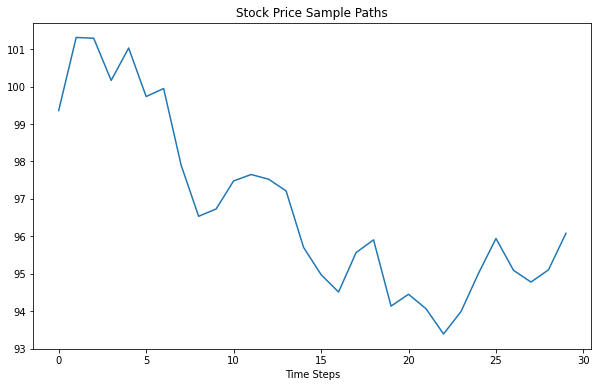

In [16]:
import matplotlib.pyplot as plt

#Plot Paths for one simulation
plt.figure(figsize=(10,6))
plt.plot(paths_train[1:31,1])
plt.xlabel('Time Steps')
plt.title('Stock Price Sample Paths')
plt.show()

### Evaluate Algorithms and Models
The approach used in the case study is Policy Gradient which is a type of Direct Policy Search (or policy-based) algorithm. In this approach we use LSTM model to map the state to action.
The hedging decision at time $t$ (represented by $\delta_t$) is path dependent and is influenced by the stock price and hedging decisions at previous time steps. Hence we must use a **RNN** that is a type of ANN that can capture the time-varying dynamics of the underlying system and is more appropriate in this context. RNNs have a memory, which captures information about what has been calculated so far. **LSTM** is a special kind of RNN capable of learning long-term dependencies. Past state information is made available to the network when mapping to an action; the extraction of relevant past data is then learned as part of the training process. We will use an LSTM model to map the state to action and get the hedging strategy ($\delta_1, \delta_2, \ldots, \delta_T$).

### Policy gradient script
We will cover the implementation steps and model training in this section. We provide the input variables —stock price path ($S_1, S_2, \ldots ST_$ ), strike, and risk aversion parameter, $\alpha$— to the trained model and receive the hedging strategy ($\delta_1, \delta_2, \ldots, \delta_T$) as the output.
The following image provides an overview of the training pf the policy gradient:
<img src="./img/training_derivative_hedging.png">
We already performed step 1 previously. The remaining steps 2-5 are implemented in the Agent class. Agent holds the variables and member functions that perform the training. An object of the “Agent” class is created using the training phase and is used for training the model. After sufficient number of iterations of steps 2-5, an optimal policy gradient model is generated. The “class” consists of two modules:

- constructor,
- function execute_graph_batchwise,

plus the functions training, predict and restore.

The **Constructor** is defined as an init function, where we define the model parameters. We define the input variables of the model (i.e., stock price path, strike, and risk aversion parameter) as *TensorFlow placeholders*. Placeholders are used to feed in data from outside the computational graph, and we feed the data of these input variables during the training phase. We implement an LSTM network in TensorFlow by using the tf.MultiRNNCell function. The LSTM model uses four layers with 62, 46, 46, and 1 nodes. The loss function is the CVaR, which is minimized when tf.train is called during the training step. We sort the negative realized PnLs of the trading strategy and calculate the mean of the $(1−\alpha)$ top losses.

The function **execute_graph_batchwise** is the key function of the program, in which we train the neural network based on the observed experience. It takes a batch of the states as input and updates the policy gradient–based LSTM model weights by minimizing CVaR. This function trains the LSTM model to predict a hedging strategy by looping across the epochs and batches. First, it prepares a batch of market variables (stock price, strike, and risk aversion) and uses sess.run function for training. This sess.run is a TensorFlow function to run any operation defined within it. Here, it takes the inputs and runs the tf.train function that was defined in the constructor. After a sufficient number of iterations, an optimal policy gradient model is generated.

The **training** function simply triggers the execute_graph_batchwise function and provides all the inputs required for training to this function. The predict function returns the action (hedging strategy) given a state (market variables). The restore function restores the saved trained model, to be used further for training or prediction

In [56]:
from IPython.core.debugger import set_trace
import tensorflow.compat.v1 as tf

tf.compat.v1.disable_eager_execution()

class Agent(object):
    def __init__(self, time_steps, batch_size, features, nodes = [62,46,46,1], name='model'):
        tf.reset_default_graph()
        self.batch_size = batch_size #NUmber of options in a batch
        self.S_t_input = tf.placeholder(tf.float32, [time_steps, batch_size, features]) #Spot
        self.K = tf.placeholder(tf.float32, batch_size) #Strike 
        self.alpha = tf.placeholder(tf.float32) #alpha for cVaR

        S_T = self.S_t_input[-1,:,0] #Spot at time T
        dS = self.S_t_input[1:, :, 0] - self.S_t_input[0:-1, :, 0] # Change in the Spot price
        #dS = tf.reshape(dS, (time_steps, batch_size))

        #Prepare S_t for the use in the RNN remove the last time step (at T the portfolio is zero)
        S_t = tf.unstack(self.S_t_input[:-1, :,:], axis=0)

        # Build the lstm
        lstm = tf.nn.rnn_cell.MultiRNNCell([tf.nn.rnn_cell.LSTMCell(n) for n in nodes])

        #So the state is a convenient tensor that holds the last actual RNN state, ignoring the zeros. 
        #The strategy tensor holds the outputs of all cells, so it doesn't ignore the zeros. 
        self.strategy, state = tf.nn.static_rnn(lstm, S_t, initial_state=lstm.zero_state(batch_size, tf.float32), \
                                                dtype=tf.float32)

        self.strategy = tf.reshape(self.strategy, (time_steps-1, batch_size))
        self.option = tf.maximum(S_T-self.K, 0)

        self.Hedging_PnL = - self.option + tf.reduce_sum(dS*self.strategy, axis=0)
        self.Hedging_PnL_Paths = - self.option + dS*self.strategy
        # Calculate the CVaR for a given confidence level alpha
        # Take the 1-alpha largest losses (top 1-alpha negative PnLs) and calculate the mean
        CVaR, idx = tf.nn.top_k(-self.Hedging_PnL, tf.cast((1-self.alpha)*batch_size, tf.int32))
        CVaR = tf.reduce_mean(CVaR)
        self.train = tf.train.AdamOptimizer().minimize(CVaR)
        self.saver = tf.train.Saver()
        self.modelname = name
        
    def _execute_graph_batchwise(self, paths, strikes, riskaversion, sess, epochs=1, train_flag=False):
        sample_size = paths.shape[1]
        batch_size=self.batch_size
        idx = np.arange(sample_size)
        start = dt.datetime.now()
        for epoch in range(epochs):
            # Save the hedging Pnl for each batch      
            pnls = []
            strategies = []            
            if train_flag:
                np.random.shuffle(idx)
            for i in range(int(sample_size/batch_size)):
                indices = idx[i*batch_size : (i+1)*batch_size]
                batch = paths[:,indices,:]
                if train_flag:#runs the train, hedging PnL and strategy using the inputs 
                    _, pnl, strategy = sess.run([self.train, self.Hedging_PnL, self.strategy], {self.S_t_input: batch,
                                                                                          self.K : strikes[indices],
                                                                                          self.alpha: riskaversion})
                else:
                    pnl, strategy = sess.run([self.Hedging_PnL, self.strategy], {self.S_t_input: batch,
                                                                                self.K : strikes[indices],
                                                                                self.alpha: riskaversion})
                pnls.append(pnl)
                strategies.append(strategy)
            #Calculate the option prive given the risk aversion level alpha
            #set_trace()
            CVaR = np.mean(-np.sort(np.concatenate(pnls))[:int((1-riskaversion)*sample_size)])
            #set_trace()
            if train_flag:
                if epoch % 10 == 0:
                    print('Time elapsed:', dt.datetime.now()-start)
                    print('Epoch', epoch, 'CVaR', CVaR)
                    #Saving the model
                    self.saver.save(sess, "model.ckpt")
        self.saver.save(sess, "model.ckpt")
        return CVaR, np.concatenate(pnls), np.concatenate(strategies,axis=1)
    
    def training(self, paths, strikes, riskaversion, epochs, session, init=True):
        if init:
            sess.run(tf.global_variables_initializer())
        self._execute_graph_batchwise(paths, strikes, riskaversion, session, epochs, train_flag=True)
        
    def predict(self, paths, strikes, riskaversion, session):
        return self._execute_graph_batchwise(paths, strikes, riskaversion,session, 1, train_flag=False)

    def restore(self, session, checkpoint):
        self.saver.restore(session, checkpoint)

### Training the data
We will proceed to train the data, based on our policy based model. This will provide us with the strategy, based on the simulated price of the stock prices at the end of the day.

Steps:

- Define the risk aversion parameter for CVaR, number of features (is the total number of stocks, in this case is just 1), strike price and define the batch size with which the neural network will be trained. The CVaR represents the amount of loss we want to minimize. For example, a CVaR of 99% means that we want to avoid extreme loss, while a CVaR of 50% minimizes average loss. We train with a CVaR of 50% to have smaller mean loss.
- Instantiate the Policy Gradient Agent which has the RNN based policy with the loss function or the reward function based on the CVaR reward
- The Training data is the Monte-Carlo path generated in the previous step.
- Instantiate the policy gradient agent, which has the RNN based-policy with the loss function based on the CVaR.
- Iterate through the batches; the strategy is defined by the policy output of the LSTM-based network.
- Finally the trained model is saved


In [57]:
batch_size = 1000 
features = 1 
K = 100
alpha = 0.50 #risk aversion parameter for cVaR
epoch = 100 #It is set to 100, but should ideally be a high number 
model_1 = Agent(paths_train.shape[0], batch_size, features, name='rnn_final')

<ipython-input-56-fe488ac8ac20>:22: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  lstm = tf.nn.rnn_cell.MultiRNNCell([tf.nn.rnn_cell.LSTMCell(n) for n in nodes])


In [58]:
import datetime as dt
# Training the model takes about a few minutes
start = dt.datetime.now()
with tf.Session() as sess:
    # Train Model
    model_1.training(paths_train, np.ones(paths_train.shape[1])*K, alpha, epoch, sess)
print('Training finished, Time elapsed:', dt.datetime.now()-start)

Time elapsed: 0:01:14.733304
Epoch 0 CVaR 3.8817694
Time elapsed: 0:08:17.988424
Epoch 10 CVaR 2.723139
Time elapsed: 0:15:39.040593
Epoch 20 CVaR 2.6238847
Time elapsed: 0:22:38.652735
Epoch 30 CVaR 2.5992043
Time elapsed: 0:29:28.220761
Epoch 40 CVaR 2.6067803
Time elapsed: 0:37:00.654851
Epoch 50 CVaR 2.5892868
Time elapsed: 0:44:29.524325
Epoch 60 CVaR 2.5870712
Time elapsed: 0:51:36.252740
Epoch 70 CVaR 2.5974944
Time elapsed: 0:58:39.986002
Epoch 80 CVaR 2.5880194
Time elapsed: 1:05:26.058536
Epoch 90 CVaR 2.5842621
Training finished, Time elapsed: 1:11:54.143753


### Testing the data
Testing is an important step, especially for RL, as it is difficult for a model to provide any meaningful, intuitive relationships between input and their corresponding out‐ put that is easily understood. In the testing step, we will compare the effectiveness of the hedging strategy and compare it to the delta hedging strategy based on the Black Scholes model. We first define the helper functions followed by the results comparison.

#### Helper Functions for Comparison against Black Scholes

In [59]:

def BS_d1(S, dt, r, sigma, K):
    return (np.log(S/K) + (r+sigma**2/2)*dt) / (sigma*np.sqrt(dt))

def BlackScholes_price(S, T, r, sigma, K, t=0):
    dt = T-t
    Phi = stats.norm(loc=0, scale=1).cdf
    d1 = BS_d1(S, dt, r, sigma, K)
    d2 = d1 - sigma*np.sqrt(dt)
    return S*Phi(d1) - K*np.exp(-r*dt)*Phi(d2)

def BS_delta(S, T, r, sigma, K, t=0):
    dt = T-t
    d1 = BS_d1(S, dt, r, sigma, K)
    Phi = stats.norm(loc=0, scale=1).cdf
    return Phi(d1)


#### Test results and plotting

The following functions are used to compute the key metrics and related plots for evaluating the effectiveness of the hedge. The function test_hedging_strategy computes different types of PnL, including CVaR, PnL, and Hedge PnL. The function plot_deltas plots the comparison of the RL delta versus Black-Scholes hedging at different time points. The function plot_strategy_pnl is used to plot the total PnL of the RL-based strategy versus Black-Scholes hedging.

In [111]:
def test_hedging_strategy(deltas, paths, K, price, alpha, output=True):
    S_returns = paths[1:,:,0]-paths[:-1,:,0]
    hedge_pnl = np.sum(deltas * S_returns, axis=0)
    option_payoff = np.maximum(paths[-1,:,0] - K, 0)
    replication_portfolio_pnls = -option_payoff + hedge_pnl + price
    mean_pnl = np.mean(replication_portfolio_pnls)
    cvar_pnl = -np.mean(np.sort(replication_portfolio_pnls)[:int((1-alpha)*replication_portfolio_pnls.shape[0])])
    if output:
        plt.hist(replication_portfolio_pnls)
        print('BS price at t0:', price)
        print('Mean Hedging PnL:', mean_pnl)
        print('CVaR Hedging PnL:', cvar_pnl)
    return (mean_pnl, cvar_pnl, hedge_pnl, replication_portfolio_pnls, deltas)

def plot_deltas(paths, deltas_bs, deltas_rnn, times=[0, 1, 5, 10, 15, 29]):
    fig = plt.figure(figsize=(10,6))
    for i, t in enumerate(times):
        plt.subplot(2,3,i+1)
        xs =  paths[t,:,0]
        ys_bs = deltas_bs[t,:]
        ys_rnn = deltas_rnn[t,:]
        df = pd.DataFrame([xs, ys_bs, ys_rnn]).T
        #df = df.groupby(0, as_index=False).agg({1:np.mean,
        #                                          2: np.mean})
        plt.plot(df[0], df[1], df[0], df[2], linestyle='', marker='x' )
        plt.legend(['BS delta', 'RNN Delta'])
        plt.title('Delta at Time %i' % t)
        plt.xlabel('Spot')
        plt.ylabel('$\Delta$')
    plt.tight_layout()
    
def plot_strategy_pnl(portfolio_pnl_bs, portfolio_pnl_rnn):
    fig = plt.figure(figsize=(10,6))
    size = portfolio_pnl_bs.shape[0]
    data = {
        'strategy': ['Black-Scholes']*size+['RNN-LSTM-v1']*size,
        'portfolio_data': np.hstack((portfolio_pnl_bs, portfolio_pnl_rnn))
    }
    sns.boxplot(x='strategy', y='portfolio_data', data=pd.DataFrame(data=data), hue='strategy')
    plt.title('Compare PnL Replication Strategy')
    plt.ylabel('PnL')  

#### Hedging Error for Black Scholes Replication
The following function is used to get the hedging strategy based on the traditional Black-Scholes model, which is further used for comparison against the RL-based hedging strategy.

In [61]:
def black_scholes_hedge_strategy(S_0, K, r, vol, T, paths, alpha, output):
    bs_price = BlackScholes_price(S_0, T, r, vol, K, 0)
    times = np.zeros(paths.shape[0])
    times[1:] = T / (paths.shape[0]-1)
    times = np.cumsum(times)    
    bs_deltas = np.zeros((paths.shape[0]-1, paths.shape[1]))
    for i in range(paths.shape[0]-1):
        t = times[i]
        bs_deltas[i,:] = BS_delta(paths[i,:,0], T, r, vol, K, t)
    return test_hedging_strategy(bs_deltas, paths, K, bs_price, alpha, output)

### Comparison between Black Scholes and Reinforcement Learning

We will compare the effectiveness of the hedging strategy by looking at the influence of the CVaR risk aversion parameter and inspect how well the RL-based model can generalize the hedging strategy if we change the moneyness of the option, the drift, and the volatility of the underlying process.


#### Test at 99% CVaR
First, we compare the average PnL and the CVaR of the trading strategies assuming we can charge the Black Scholes price for the option.

The CVaR represents the amount of loss we want to minimize. We trained the model using a risk aversion of 50% to minimize average loss. However, for testing purposes we increase the risk aversion to 99%, meaning that we want to avoid extreme loss. These results are compared against the Black-Scholes model.

In [62]:
S_0 = 100
K = 100
r = 0
vol = 0.2
T = 1/12
timesteps = 30
seed_test = 21122017
n_sims_test = 10000

In [63]:
# Monte Carlo Path for the test set
alpha = 0.99
paths_test =  monte_carlo_paths(S_0, T, vol, r, seed_test, n_sims_test, timesteps)

In [64]:
with tf.Session() as sess:
    model_1.restore(sess, 'model.ckpt')
    #Using the model_1 trained in the section above
    test1_results = model_1.predict(paths_test, np.ones(paths_test.shape[1])*K, alpha, sess)

INFO:tensorflow:Restoring parameters from model.ckpt


BS price at t0: 2.3029744678024286
Mean Hedging PnL: -0.0010458505607415436
CVaR Hedging PnL: 1.2447953011695538
BS price at t0: 2.302974467802428
Mean Hedging PnL: 0.00019411333793684413
CVaR Hedging PnL: 1.2382436137662913


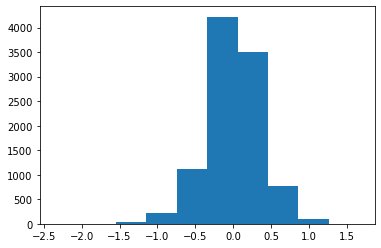

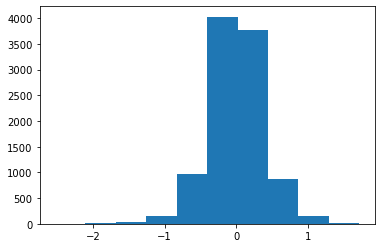

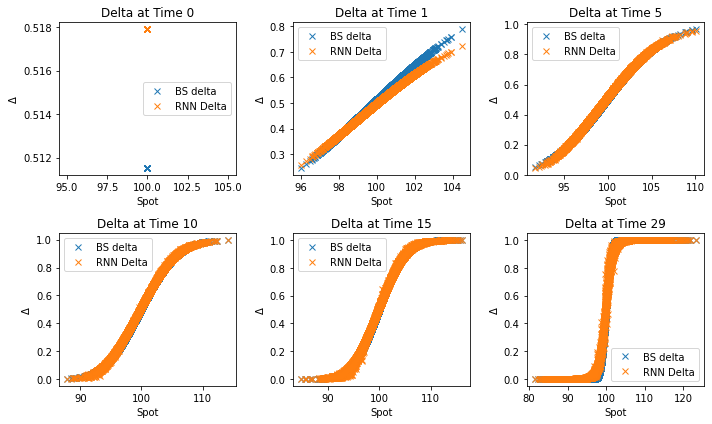

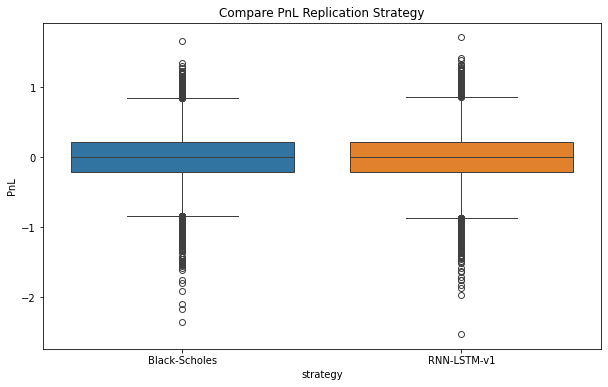

In [112]:
import seaborn as sns
import scipy.stats as stats
import pandas as pd

_,_,_,portfolio_pnl_bs, deltas_bs = black_scholes_hedge_strategy(S_0,K, r, vol, T, paths_test, alpha, True)
plt.figure()
_,_,_,portfolio_pnl_rnn, deltas_rnn = test_hedging_strategy(test1_results[2], paths_test, K, 2.302974467802428, alpha, True)
plot_deltas(paths_test, deltas_bs, deltas_rnn)
plot_strategy_pnl(portfolio_pnl_bs, portfolio_pnl_rnn)

For the first test set (strike 100, same drift, same vol) the results looks quite good. We see that the delta from both Black-Scholes and the RL- based approach converge over time from day 1 to 30. The CVaRs of both strategies are similar and lower in magnitude, with values of 1.24 and 1.38 for Black-Scholes and RL, respectively. Also, the volatility of the two strategies is similar.


### Changing Moneyness

Let us now look at the comparison of the strategies, when the moneyness, defined as the ratio of strike to spot price, is changed. 

In [113]:
with tf.Session() as sess:
    model_1.restore(sess, 'model.ckpt')
    #Using the model_1 trained in the section above
    test_results_Moneyness = model_1.predict(paths_test, np.ones(paths_test.shape[1])*(K-10), alpha, sess)

INFO:tensorflow:Restoring parameters from model.ckpt


BS price at t0: 10.07339936955367
Mean Hedging PnL: 0.0007508571761945079
CVaR Hedging PnL: 0.6977526775080664
BS price at t0: 10.073
Mean Hedging PnL: -0.036452333445892465
CVaR Hedging PnL: 3.2088039941579507


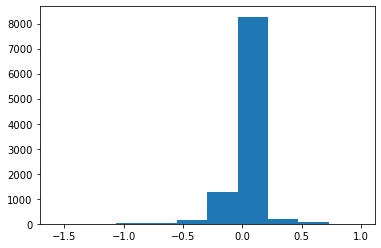

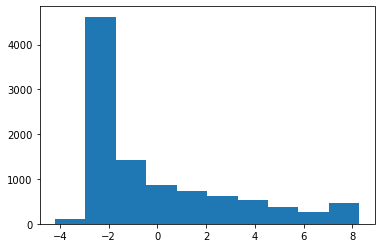

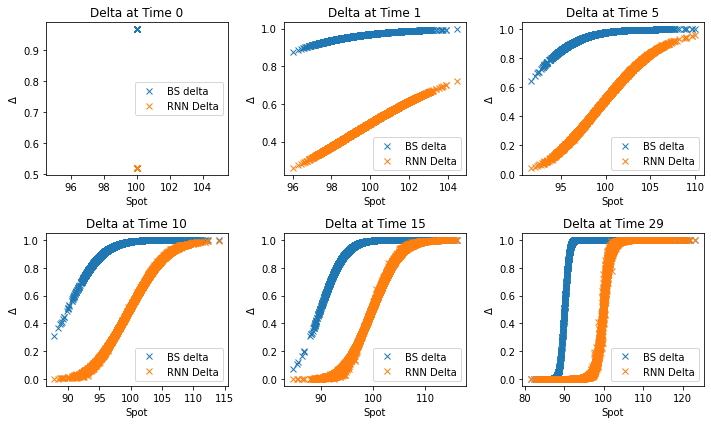

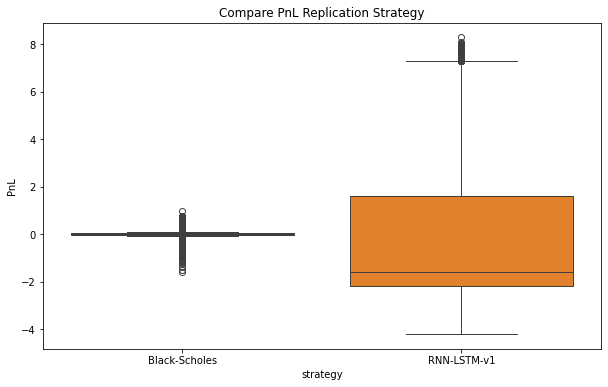

In [114]:
_,_,_,portfolio_pnl_bs, deltas_bs = black_scholes_hedge_strategy(S_0,K-10, r, vol, T, paths_test, alpha, True)
plt.figure()
_,_,_,portfolio_pnl_rnn, deltas_rnn = test_hedging_strategy(test_results_Moneyness[2], paths_test, K-10, 10.073, alpha, True)
plot_deltas(paths_test, deltas_bs, deltas_rnn)
plot_strategy_pnl(portfolio_pnl_bs, portfolio_pnl_rnn)

With the change in the moneyness, we see that the PnL of the RL strategy is significantly worse than that of the Black-Scholes strategy. We see a significant deviation of the delta between the two across all the days. The CVaR and the volatility of the RL-based strategy is much higher. **The results indicate that we should be careful while generalizing the model to different levels of moneyness and should train the model with the option of using a variety of strikes before implementing it in a production environment**.

### Changing Drift
Let us now look at the comparison of the strategies when the drift is changed. In order to change the drift, we assume the drift of the stock price is 4% per month, or 48% annualized. 

In [115]:
# Test set 2: Assume the drift of the underlying is 4% per month under the real world measure 
paths_test_drift = monte_carlo_paths(S_0, T, vol, 0.48+r, seed_test, n_sims_test, timesteps)

In [117]:
with tf.Session() as sess:
    model_1.restore(sess, 'model.ckpt')
    #Using the model_1 trained in the section above
    test_results_drift = model_1.predict(paths_test_drift, np.ones(paths_test_drift.shape[1])*K, alpha, sess)

INFO:tensorflow:Restoring parameters from model.ckpt


BS price at t0: 2.3029744678024286
Mean Hedging PnL: -0.017239029648273875
CVaR Hedging PnL: 1.2141220199385758
BS price at t0: 2.3029
Mean Hedging PnL: 0.0020054096348563286
CVaR Hedging PnL: 1.172791841686713


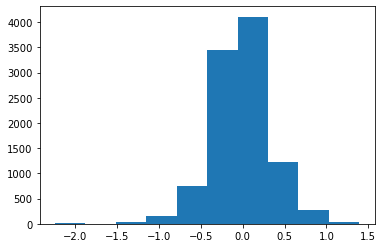

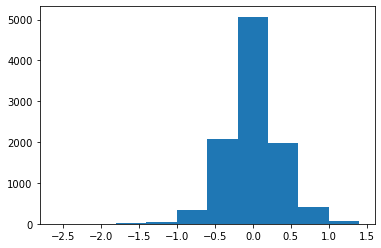

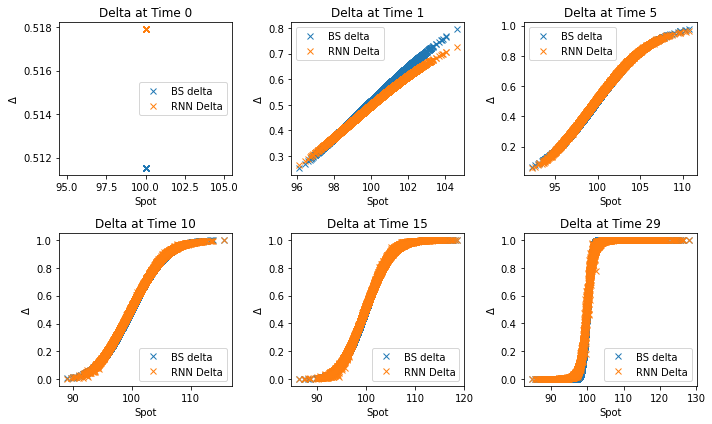

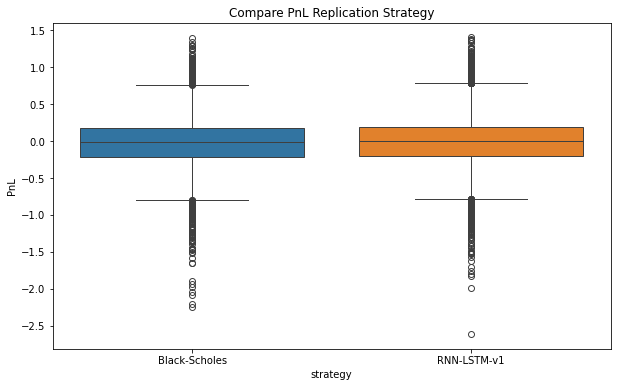

In [118]:

_,_,_,portfolio_pnl_bs, deltas_bs = black_scholes_hedge_strategy(S_0,K,r, vol, T, paths_test_drift, alpha, True)
plt.figure()
_,_,_,portfolio_pnl_rnn, deltas_rnn = test_hedging_strategy(test_results_drift[2], paths_test_drift, K, 2.3029, alpha, True)
plot_deltas(paths_test_drift, deltas_bs, deltas_rnn)
plot_strategy_pnl(portfolio_pnl_bs, portfolio_pnl_rnn)

The overall results look good for the change in drift. The conclusion is similar to results when the risk aversion was changed, with the deltas for the two approaches converging over time.

### Shifted Volatility
Finally, we look at the impact of shifting the volatility. In order to change the volatility, we increase it by 5%.

In [120]:
# Test set 3: Assume the volatility is not constant and the realized volatility is 5% higher 
# than the implied (historical observed) one
paths_test_vol = monte_carlo_paths(S_0, T, vol+0.05, r, seed_test, n_sims_test, timesteps)

In [121]:
with tf.Session() as sess:
    model_1.restore(sess, 'model.ckpt')
    #Using the model_1 trained in the section above
    test_results_vol = model_1.predict(paths_test_vol, np.ones(paths_test_vol.shape[1])*K, alpha, sess)

INFO:tensorflow:Restoring parameters from model.ckpt


BS price at t0: 2.3029744678024286
Mean Hedging PnL: -0.5787493248269506
CVaR Hedging PnL: 2.558392282440757
BS price at t0: 2.309
Mean Hedging PnL: -0.5711533935563108
CVaR Hedging PnL: 2.5204670663364572


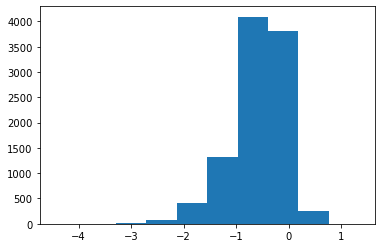

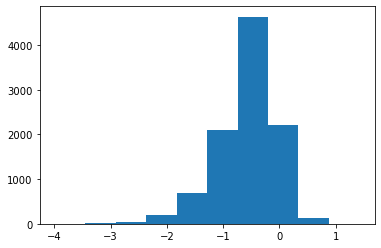

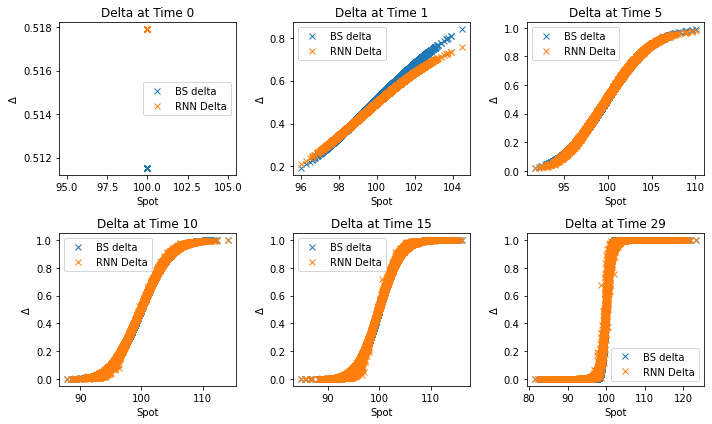

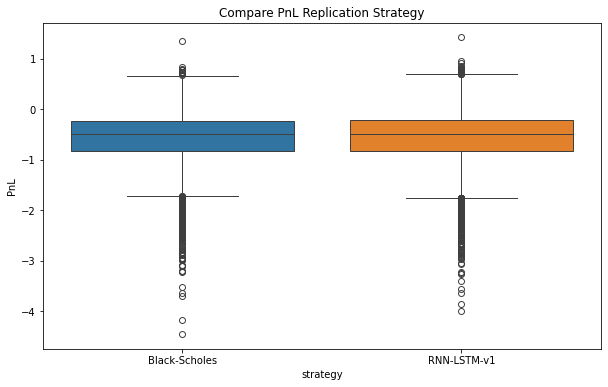

In [122]:
_,_,_,portfolio_pnl_bs, deltas_bs = black_scholes_hedge_strategy(S_0,K, r, vol, T, paths_test_vol, alpha, True)
plt.figure()
_,_,_,portfolio_pnl_rnn, deltas_rnn = test_hedging_strategy(test_results_vol[2], paths_test_vol, K, 2.309, alpha, True)
plot_deltas(paths_test, deltas_bs, deltas_rnn)
plot_strategy_pnl(portfolio_pnl_bs, portfolio_pnl_rnn)

Looking at the results, the delta, CVaR, and overall volatility of both models are similar. Hence looking at the different comparisons overall, the performance of this RL-based hedging is on par with Black-Scholes–based hedging.

#### Conclusion

In this case study, we compared the effectiveness of a call option hedging strategy using RL. The RL-based hedging strategy did quite well even when certain input parameters were modified. However, **this strategy was not able to generalize the strategy for options at different moneyness levels. It underscores the fact that RL is a dataintensive approach, and it is important to train the model with different scenarios**, which becomes more important if the model is intended to be used across a wide variety of derivatives. The RL model can be further trained using a wide variety of instruments with different hyperparameters, leading to performance enhancements.